## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

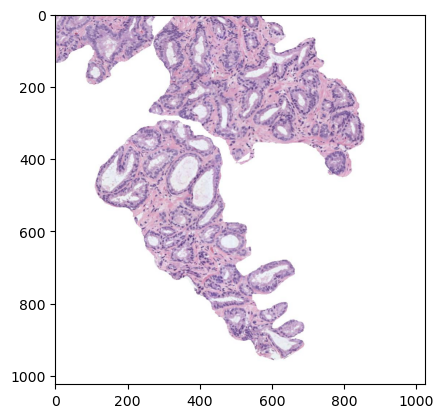

In [1]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB
import skimage.io as io
from skimage import io, img_as_float
import matplotlib.pyplot as plt
import numpy as np
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB
imagen = io.imread('histo_2.jpg')

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
imagen_normalizada = img_as_float(imagen)

# Visualizar la imagen
plt.imshow(imagen_normalizada)
plt.show()


#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

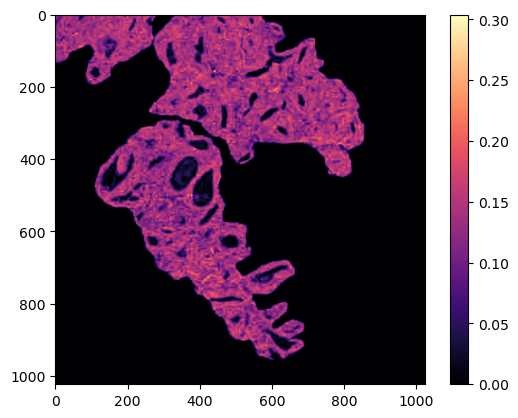

In [2]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Primero aseguramos que todos los valores sean no negativos aplicando la función np.clip
magenta = np.clip((imagen_normalizada[:, :, 0] + imagen_normalizada[:, :, 2])/2 - imagen_normalizada[:, :, 1], 0, 1)

# Visualizar la imagen del canal magenta
plt.imshow(magenta, cmap='magma')
plt.colorbar()
plt.show()


#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

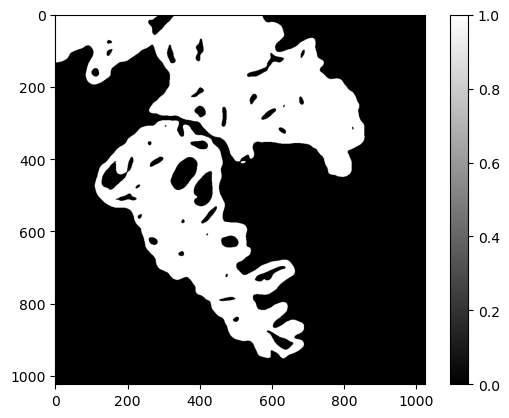

In [3]:
# Importar las funciones necesarias
from skimage import filters, img_as_ubyte
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte
from scipy.ndimage import gaussian_filter

# Aplicar un filtro gaussiano de tamaño 5x5
magenta_gaussiana = gaussian_filter(magenta, sigma=5)

# Escalar la imagen filtrada a un rango de 0 a 255 y convertirla a un formato de 8 bits sin signo (uint8)
magenta_gaussiana_uint8 = img_as_ubyte(magenta_gaussiana)

# Aplicar el método de Otsu para obtener el umbral
umbral = threshold_otsu(magenta_gaussiana_uint8)

# Crear la máscara binaria de la imagen en la que los píxeles con un valor superior al umbral se asignan como 1s y el resto como 0s
mascara = magenta_gaussiana_uint8 > umbral

# Visualizar la máscara resultante
plt.imshow(mascara, cmap='gray')
plt.colorbar()
plt.show()


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

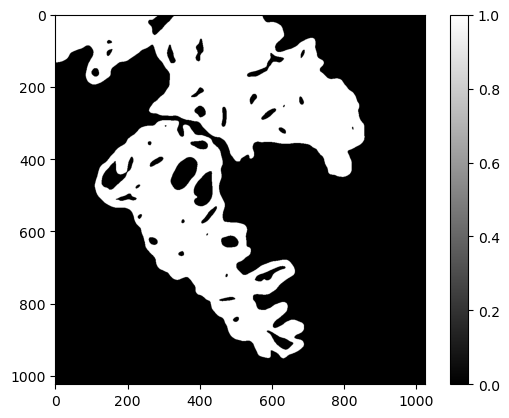

In [4]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante# Importar la función necesaria
# Importar la función necesaria
from skimage.morphology import remove_small_objects

# Eliminar objetos pequeños
mascara_limpia = remove_small_objects(mascara, min_size=300)

# Visualizar la máscara resultante
plt.imshow(mascara_limpia, cmap='gray')
plt.colorbar()
plt.show()


#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

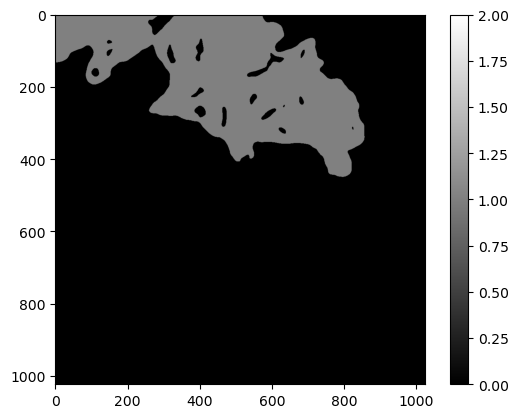

In [5]:
# Importar las funciones necesarias
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
from scipy import ndimage as ndi

# Convertir la máscara a un formato de enteros
mascara_limpia_int = img_as_ubyte(mascara_limpia)

# Etiquetar los componentes conectados en la imagen
etiquetas = label(mascara_limpia_int)

# Cambiar el tipo de datos de las etiquetas a int32
etiquetas = etiquetas.astype(np.int32)

# Identificar los dos picos máximos locales en la imagen como semillas
seeds = peak_local_max(mascara_limpia_int, num_peaks=2, labels=etiquetas)

# Crear una matriz de semillas con las mismas dimensiones que la imagen
semillas = np.zeros(mascara_limpia_int.shape, dtype=np.int32)
semillas[seeds[:, 0], seeds[:, 1]] = np.arange(len(seeds)) + 1

# Calcular las distancias desde el fondo de la imagen
distancias = ndi.distance_transform_edt(mascara_limpia_int)

# Aplicar el algoritmo de región de crecimiento
segmentos = watershed(-distancias, semillas.astype(np.int32), mask=mascara_limpia_int)

# Visualizar la máscara resultante
plt.imshow(segmentos, cmap='gray')
plt.colorbar()
plt.show()


#### 5) Rellenar los objetos de los lúmenes

C:\Users\julis\AppData\Local\Temp\ipykernel_22720\345771081.py:2: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_fill_holes


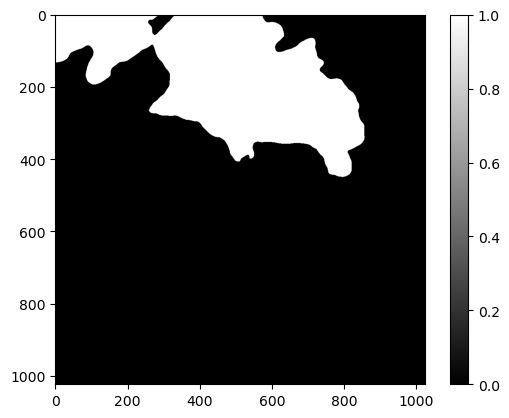

In [6]:
# Importar la función necesaria
from scipy.ndimage.morphology import binary_fill_holes

# Rellenar los lúmenes
lumenes_llenos = binary_fill_holes(segmentos)

# Visualizar la máscara resultante
plt.imshow(lumenes_llenos, cmap='gray')
plt.colorbar()
plt.show()


#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

C:\Users\julis\AppData\Local\Temp\ipykernel_22720\846144179.py:5: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_fill_holes


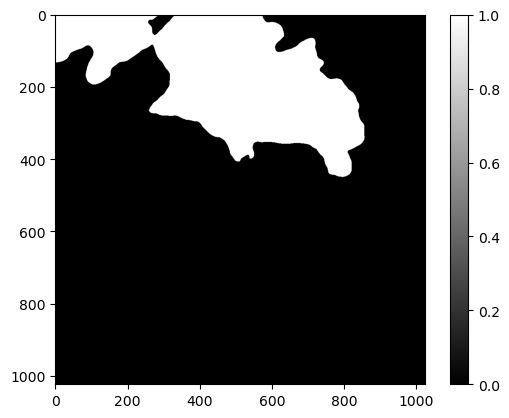

In [7]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta
# Importar la función necesaria
from scipy.ndimage.morphology import binary_fill_holes

# Rellenar los lúmenes
lumenes_llenos = binary_fill_holes(segmentos)

# Visualizar la máscara resultante
plt.imshow(lumenes_llenos, cmap='gray')
plt.colorbar()
plt.show()


#### 7) Identificar y cropear el lumen más grande

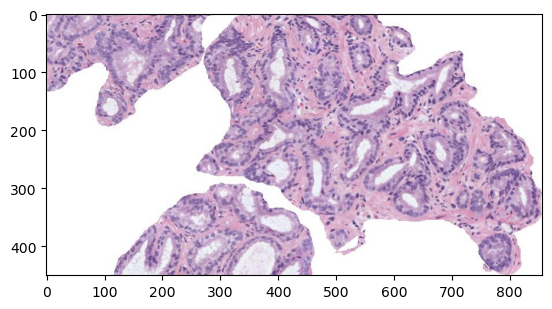

In [8]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.
# Importar las funciones necesarias
from skimage.measure import label, regionprops

# Etiquetar los lúmenes
lumenes_etiquetados = label(lumenes_llenos)

# Calcular las propiedades de las regiones
propiedades = regionprops(lumenes_etiquetados)

# Encontrar el lumen de mayor área
lumen_mayor = max(propiedades, key=lambda x: x.area)

# Obtener las coordenadas del lumen de mayor área
minr, minc, maxr, maxc = lumen_mayor.bbox

# Recortar la imagen original
imagen_cropeada = imagen[minr:maxr, minc:maxc]

# Visualizar el lumen cropeado
plt.imshow(imagen_cropeada)
plt.show()


#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [9]:
# Calcular y mostrar las propiedades del lumen de mayor área
print(f"1) Área: {round(lumen_mayor.area, 4)}")
print(f"2) Área de la bounding box: {round((maxr - minr) * (maxc - minc), 4)}")
print(f"3) Área convexa: {round(lumen_mayor.convex_area, 4)}")
print(f"4) Excentricidad: {round(lumen_mayor.eccentricity, 4)}")
print(f"5) Diámetro equivalente: {round(lumen_mayor.equivalent_diameter, 4)}")
print(f"6) Extensión: {round(lumen_mayor.extent, 4)}")
print(f"7) Diámetro Feret: {round(lumen_mayor.feret_diameter_max, 4)}")
print(f"8) Longitud del eje mayor: {round(lumen_mayor.major_axis_length, 4)}")
print(f"9) Longitud del eje menor: {round(lumen_mayor.minor_axis_length, 4)}")
print(f"10) Orientación: {round(lumen_mayor.orientation, 4)}")
print(f"11) Perímetro: {round(lumen_mayor.perimeter, 4)}")
print(f"12) Solidez: {round(lumen_mayor.solidity, 4)}")
print(f"13) Compacidad: {round(lumen_mayor.perimeter**2 / (4 * np.pi * lumen_mayor.area), 4)}")


1) Área: 201254
2) Área de la bounding box: 386507
3) Área convexa: 260347
4) Excentricidad: 0.9278
5) Diámetro equivalente: 506.206
6) Extensión: 0.5207
7) Diámetro Feret: 929.1765
8) Longitud del eje mayor: 896.7671
9) Longitud del eje menor: 334.5432
10) Orientación: 1.2214
11) Perímetro: 3078.5079
12) Solidez: 0.773
13) Compacidad: 3.7474
